# Operações de mutação
Após executar o notebook de **classificação**, podemos realizar operações de mutação no texto para verificar qual impacto elas têm na classificação dos níveis de dificuldade do texto.

In [1]:
import pandas as pd
import numpy as np
import random

random.seed(8)

## Leitura dos dados

In [2]:
# Read dataset into Pandas DataFrame
df = pd.read_csv('dataset.csv', index_col='id')
df.head()

,text,label
id,,
207_765,"nada impede, no entanto, que sejam substituído...",1
232_790,e muitas palavras faladas por esses povos fora...,1
39_347,"sete séculos antes do nascimento de cristo, o ...",1
48_379,voar sempre foi um dos grandes sonhos da human...,1
73_629,"para os bolsos de seus senhores, é claro. você...",1


In [3]:
# download nltk required packages
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /home/caio/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/caio/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [4]:
import pickle
import os
from src.CustomPortugueseLemmatizer import CustomPortugueseLemmatizer

path = 'pickle'
if os.path.isdir(path):
    # Read the Naive Bayes classifier from pickle
    with open(f'{path}/pipeline_NB.pickle', 'rb') as nb_pickle:
        pipeNB = pickle.load(nb_pickle)

    # Read the SVC classifier from pickle
    with open(f'{path}/pipeline_SVC.pickle', 'rb') as svc_pickle:
        pipeSVC = pickle.load(svc_pickle)

## Troca de palavras

In [5]:
from nltk.corpus import wordnet 

def get_synonyms(word):
    """
    Get synonyms of a word
    """
    synonyms = set()
    
    for syn in wordnet.synsets(word, lang='por'): 
        for l in syn.lemmas(lang='por'): 
            synonym = l.name().replace("_", " ").replace("-", " ").lower()
            synonym = "".join([char for char in synonym if char in ' qwertyuiopasdfghjklçzxcvbnmáàãâéêíóõôúü'])
            synonyms.add(synonym) 
    
    if word in synonyms:
        synonyms.remove(word)
    
    return list(synonyms)

In [6]:
def synonym_replacement(words, stop_words, n):
    if n <= 0: # no word to replace, return the original text
        return words
        
    words = words.split()

    new_words = words.copy()
    random_word_list = list(set([word for word in words if word not in stop_words]))
    random.shuffle(random_word_list)
    num_replaced = 0
    
    for random_word in random_word_list:
        synonyms = get_synonyms(random_word)
        
        if len(synonyms) >= 1:
            synonym = random.choice(list(synonyms))
            new_words = [synonym if word == random_word else word for word in new_words]
            num_replaced += 1
        
        if num_replaced >= n: #only replace up to n words
            break

    sentence = ' '.join(new_words)

    return sentence

### Teste com um texto exemplo

In [7]:
from sklearn.model_selection import train_test_split

X = df['text']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=32)

In [8]:
# Retrieve the last text from the test set
text = X_test.iloc[-1]
print(text)

a prostituição é uma atividade antiquíssima e que sempre encontra espaço nas sociedades. em geral, os clientes procuram esse tipo de profissional porque têm dificuldades de conseguir parceiros sexuais ou então para procurar diversidade em seus relacionamentos sexuais. porém, em termos psicológicos, geralmente é uma relação desprovida de afeto. e o sexo, dizem as pesquisas, é mais gratificante quando expressa um real sentimento entre os parceiros. durante a relação sexual, são comuns os gritos, gemidos, sussurros e palavreados obscenos, supostamente denotando excitação sexual. porém estudos recentes indicam que, na maioria das vezes, tal comportamento não reflete real excitação sexual, mas apenas o desejo de estimular sexualmente o parceiro. existem uma diferenciação no papel de cada gênero sexual dentro da relação afetiva. estudos indicam, por exemplo, que um casamento tem mais chances de ser bem-sucedido se a mulher for mais inteligente, mais jovem ou mais feliz com a relação que o ho

In [9]:
import spacy

spacy_nlp = spacy.load("pt_core_news_sm")
stop_words = spacy_nlp.Defaults.stop_words

In [10]:
sentence = synonym_replacement(text, stop_words, len(text.split()) * 0.5)
print(sentence)

a prostituição é uma ação antiquíssima e que sempre encontra espaço nas sociedades. em geral, os clientes procuram esse tipo de quem pratica uma profissão porque têm dificuldades de ser bem sucedidos parceiros sexuais ou então para revistar diversidade em seus relacionamentos sexuais. porém, em termos psicológicos, generalmente é uma relação desprovida de afeto. e o sexo, dizem as pesquisas, é mais gratificante quando expressa um atual abalo entre os parceiros. durante a relação sexual, são comuns os gritos, gemidos, sussurros e palavreados obscenos, pretensamente denotando emoção sexual. porém estudos recentes indicam que, na maioria das vezes, tal maneira não reflete atual emoção sexual, mas apenas o pretensão de propulsar sexualmente o parceiro. existem uma diferenciação biologia no folha de cada género sexual dentro da relação afetiva. estudos indicam, por exemplo, que um matrimônio tem mais chance de ser bem sucedido se a dama for mais inteligente, mais garina ou mais jovial com a

In [11]:
# Create list of texts to predict
X_eval = [text]
label_NB = pipeNB.predict(X_eval)
label_SVC = pipeSVC.predict(X_eval)

print(f'Naive Bayes label: {label_NB}')
print(f'SVC label: {label_SVC}')
print(f'Correct label: {y_test[-1]}')

Naive Bayes label: [4]
SVC label: [3]
Correct label: 3


### Avaliação da influência da troca de palavras

In [12]:
from sklearn.metrics import accuracy_score

In [14]:
accuracy_NB = []
accuracy_SVC = []

percentage_range = np.arange(0, 1, step=0.05)
for percent in percentage_range:
    X_test_syn  = [synonym_replacement(text, len(text.split()) * percent) for text in X_test]
    
    predictions_NB = pipeNB.predict(X_test_syn)
    accuracy_NB.append(accuracy_score(y_test, predictions_NB))
    predictions_SVC = pipeSVC.predict(X_test_syn)
    accuracy_SVC.append(accuracy_score(y_test, predictions_SVC))

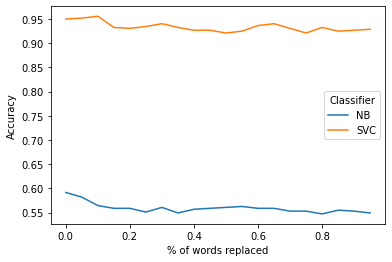

In [15]:
import matplotlib.pyplot as plt

plt.plot(percentage_range, accuracy_NB, label='NB')
plt.plot(percentage_range, accuracy_SVC, label='SVC')
plt.ylabel('Accuracy')
plt.xlabel('% of words replaced')
plt.legend(title='Classifier')
plt.savefig('figures/accuracy_replacement.png', dpi=200)
plt.show()

## Troca de gênero

In [47]:
def swap_gender(text, spacy_nlp):
    # map of pronouns
    gen_map = {
        'ele': 'ela', 
        'ela': 'ele', 
        'eles': 'elas', 
        'elas': 'eles', 
        'meu': 'minha', 
        'minha': 'meu', 
        'meus': 'minhas', 
        'minhas': 'meus', 
        'teu': 'tua', 
        'tua': 'teu', 
        'teus': 'tuas', 
        'tuas': 'teus', 
        'seu': 'sua', 
        'sua': 'seu', 
        'seus': 'suas', 
        'suas': 'seus', 
        'este': 'esta', 
        'esta': 'este', 
        'estes': 'estas', 
        'estas': 'estes', 
        'esse': 'essa', 
        'essa': 'esse', 
        'esses': 'essas', 
        'essas': 'esses', 
        'aquele': 'aquela', 
        'aquela': 'aquele', 
        'aqueles': 'aquelas', 
        'aquelas': 'aqueles', 
        'àquele': 'àquela', 
        'àquela': 'àquele', 
        'àqueles': 'àquelas', 
        'àquelas': 'àqueles', 
        'mesmo': 'mesma', 
        'mesma': 'mesmo', 
        'mesmos': 'mesmas', 
        'mesmas': 'mesmos', 
        'próprio': 'própria', 
        'própria': 'próprio', 
        'próprios': 'próprias', 
        'próprias': 'próprios', 
        'todo': 'toda', 
        'toda': 'todo', 
        'todos': 'todas', 
        'todas': 'todos', 
        'algum': 'alguma', 
        'alguma': 'algum', 
        'alguns': 'algumas', 
        'algumas': 'alguns', 
        'um': 'uma', 
        'uma': 'um', 
        'uns': 'umas', 
        'umas': 'uns', 
        'certo': 'certa', 
        'certa': 'certo', 
        'certos': 'certas', 
        'certas': 'certos', 
        'vários': 'várias', 
        'várias': 'vários', 
        'muito': 'muita', 
        'muita': 'muito', 
        'muitos': 'muitas', 
        'muitas': 'muitos', 
        'quanto': 'quanta', 
        'quanta': 'quanto', 
        'quantos': 'quantas', 
        'quantas': 'quantos', 
        'tanto': 'tanta', 
        'tanta': 'tanto', 
        'tantos': 'tantas', 
        'tantas': 'tantos', 
        'outro': 'outra', 
        'outra': 'outro', 
        'outros': 'outras', 
        'outras': 'outros', 
    }
    
    word_list = []

    for token in spacy_nlp(text):
        word = token.text
        if word in gen_map.keys():
            word = gen_map[word]
        word_list.append(word)
        
    sentence = ' '.join(word_list)
    return sentence

In [44]:
X_test_trans = []

for text in X_test:
    X_test_trans.append(swap_gender(text, spacy_nlp))

In [46]:
predictions_NB = pipeNB.predict(X_test)
predictions_NBtrans = pipeNB.predict(X_test_trans)

print(f'NB accuracy (original): {accuracy_score(y_test, predictions_NB):.2f}')
print(f'NB accuracy (back_translated): {accuracy_score(y_test, predictions_NBtrans):.2f}')

predictions_SVC = pipeSVC.predict(X_test)
predictions_SVCtrans = pipeSVC.predict(X_test_trans)

print(f'SVC accuracy (original): {accuracy_score(y_test, predictions_SVC):.2f}')
print(f'SVC accuracy (back_translated): {accuracy_score(y_test, predictions_SVCtrans):.2f}')

NB accuracy (original): 0.59
NB accuracy (back_translated): 0.59
SVC accuracy (original): 0.95
SVC accuracy (back_translated): 0.95


## Paráfrase

In [13]:
from deep_translator import GoogleTranslator

In [14]:
supported_languages = GoogleTranslator.get_supported_languages()
print(f'Number of supported languages: {len(supported_languages)}')
print(supported_languages)

Number of supported languages: 109
['afrikaans', 'albanian', 'amharic', 'arabic', 'armenian', 'azerbaijani', 'basque', 'belarusian', 'bengali', 'bosnian', 'bulgarian', 'catalan', 'cebuano', 'chichewa', 'chinese (simplified)', 'chinese (traditional)', 'corsican', 'croatian', 'czech', 'danish', 'dutch', 'english', 'esperanto', 'estonian', 'filipino', 'finnish', 'french', 'frisian', 'galician', 'georgian', 'german', 'greek', 'gujarati', 'haitian creole', 'hausa', 'hawaiian', 'hebrew', 'hindi', 'hmong', 'hungarian', 'icelandic', 'igbo', 'indonesian', 'irish', 'italian', 'japanese', 'javanese', 'kannada', 'kazakh', 'khmer', 'kinyarwanda', 'korean', 'kurdish', 'kyrgyz', 'lao', 'latin', 'latvian', 'lithuanian', 'luxembourgish', 'macedonian', 'malagasy', 'malay', 'malayalam', 'maltese', 'maori', 'marathi', 'mongolian', 'myanmar', 'nepali', 'norwegian', 'odia', 'pashto', 'persian', 'polish', 'portuguese', 'punjabi', 'romanian', 'russian', 'samoan', 'scots gaelic', 'serbian', 'sesotho', 'shona',

In [15]:
translated = GoogleTranslator(source='pt', target='en').translate(text)
back_translated = GoogleTranslator(source='en', target='pt').translate(translated)

print(f'Original Text [pt]: {text}\n')
print(f'Translated Text [en]: {translated}\n')
print(f'Back Translation [pt]: {back_translated}')

Original Text [pt]: a prostituição é uma atividade antiquíssima e que sempre encontra espaço nas sociedades. em geral, os clientes procuram esse tipo de profissional porque têm dificuldades de conseguir parceiros sexuais ou então para procurar diversidade em seus relacionamentos sexuais. porém, em termos psicológicos, geralmente é uma relação desprovida de afeto. e o sexo, dizem as pesquisas, é mais gratificante quando expressa um real sentimento entre os parceiros. durante a relação sexual, são comuns os gritos, gemidos, sussurros e palavreados obscenos, supostamente denotando excitação sexual. porém estudos recentes indicam que, na maioria das vezes, tal comportamento não reflete real excitação sexual, mas apenas o desejo de estimular sexualmente o parceiro. existem uma diferenciação no papel de cada gênero sexual dentro da relação afetiva. estudos indicam, por exemplo, que um casamento tem mais chances de ser bem-sucedido se a mulher for mais inteligente, mais jovem ou mais feliz co

In [17]:
X_test_trans = []
to_remove = []

for i, text in enumerate(X_test):
    translated = GoogleTranslator(source='pt', target='en').translate(text)
    
    if len(translated) < 5000:
        # text must have less than 5000 characters
        back_translated = GoogleTranslator(source='en', target='pt').translate(translated)
        X_test_trans.append(back_translated)
    else:
        to_remove.append(i)

In [20]:
# drop rows which could not be translated
X_test_drop = X_test.drop(X_test.index[to_remove])
y_test_drop = y_test.drop(y_test.index[to_remove])

In [31]:
predictions_NB = pipeNB.predict(X_test_drop)
predictions_NBtrans = pipeNB.predict(X_test_trans)

print(f'NB accuracy (original): {accuracy_score(y_test_drop, predictions_NB):.2f}')
print(f'NB accuracy (back_translated): {accuracy_score(y_test_drop, predictions_NBtrans):.2f}')

predictions_SVC = pipeSVC.predict(X_test_drop)
predictions_SVCtrans = pipeSVC.predict(X_test_trans)

print(f'SVC accuracy (original): {accuracy_score(y_test_drop, predictions_SVC):.2f}')
print(f'SVC accuracy (back_translated): {accuracy_score(y_test_drop, predictions_SVCtrans):.2f}')

NB accuracy (original): 0.59
NB accuracy (back_translated): 0.59
SVC accuracy (original): 0.95
SVC accuracy (back_translated): 0.94
